# KS ANALYSIS FOR SCENES365 HDRPLUS


The effect of the image enhancement operator is computed using this function: 

\begin{equation}
L_{\mathrm{out}} = \frac{L_{\mathrm{in}}^{\gamma}}{L_{\mathrm{in}}^{\gamma} + \mu^{\gamma}} 
\end{equation}

See paper for more details

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def cluster_names(df,
                  column_names,
                  red_column_names,
                  name_thr=0.6,
                  add_names_column=True):
    
    df_labels = list(set(df["labels"].values))
    
    cluster_names = []
    cluster_counts = []
    
    for label in df_labels:
        df_cluster = df[df["labels"]==label]
        
        df_cluster_counts = df_cluster[column_names].sum().values / len(df_cluster)
        df_cluster_counts = np.where(df_cluster_counts <= name_thr, df_cluster_counts, 1.0)
        df_cluster_counts = np.where(df_cluster_counts > name_thr, df_cluster_counts, 0.0)
        
        clust_name = ""
        for j, count in enumerate(df_cluster_counts):   
            if count == 1:
                clust_name += red_column_names[j] 
        
        cluster_names.append(clust_name)
        cluster_counts.append(df_cluster_counts)
        
      
    cluster_names =  cluster_names[:-1] + ["UN"]

    if add_names_column:
        map_label_names = {}
        
        for j, c_name in enumerate(cluster_names):
            if j == len(cluster_names)-1:
                j = -1
            map_label_names[j] = c_name
        
        df["label_name"] = df["labels"].map(map_label_names)

    return cluster_names, cluster_counts

In [3]:
def assign_luminosity_level(df):
    df["luminosity"] = ["0low lum"]*len(df)
    df.loc[df["avg lum"] == 1 , "luminosity"] = "1avg lum"
    df.loc[df["high lum"] == 1 , "luminosity"] = "2high lum"
    return None

In [4]:
def plot_parameter_distribution_per_light_source(df, param="a", n_bins=50):
    df = df[df["b"] < 1e10]
    df = df[df["a"] < 1e10]
    RD_a_low = df[df["light_source"]=="indoor"][param].values
    RD_a_high = df[df["light_source"]=="outdoor"][param].values
    
    plt.hist(RD_a_low, n_bins, weights=np.ones(len(RD_a_low)) / len(RD_a_low), color="r", label="indoor",alpha=0.3)
    plt.hist(RD_a_high, n_bins, weights=np.ones(len(RD_a_high)) / len(RD_a_high), color="g", label="outdoor",alpha=0.3)
    
    plt.legend()
    if param == "a":
        title = r"$\gamma$"
    elif param == "b":
        title = r"$\mu$"
    else:
        title = param
    plt.title(title)

In [5]:
def plot_parameter_distribution_per_luminosity(df, param="a", n_bins=50):
    df = df[df["b"] < 1e10]
    df = df[df["a"] < 1e10]
    RD_a_low = df[df["luminosity"]=="0low lum"][param].values
    RD_a_avg = df[df["luminosity"]=="1avg lum"][param].values
    RD_a_high = df[df["luminosity"]=="2high lum"][param].values
    
    plt.hist(RD_a_low, n_bins, weights=np.ones(len(RD_a_low)) / len(RD_a_low), color="r", label="low",alpha=0.3)
    plt.hist(RD_a_avg, n_bins, weights=np.ones(len(RD_a_avg)) / len(RD_a_avg), color="b", label="avg",alpha=0.3)
    plt.hist(RD_a_high, n_bins, weights=np.ones(len(RD_a_high)) / len(RD_a_high), color="g", label="low",alpha=0.3)
    
    plt.legend()
    if param == "a":
        title = r"$\gamma$"
    elif param == "b":
        title = r"$\mu$"
    else:
        title = param
    plt.title(title)

In [6]:
def param_distr_per_feature(df, feature):
    
    features = list(set(df[feature].values))
    print(features)
    a_feature = []
    b_feature = []
    
    for j in features:
        a_feature.append(df[df[feature]==j]["a"].values)
        b_feature.append(df[df[feature]==j]["b"].values)

    return a_feature, b_feature

In [7]:
def ks_test(p_distributions, p_names, plot=True, alpha=0.05, title=None, cbar=False, save_path=''):
    
    p_values = []
    
    for i in range(len(p_distributions)):
        p_value_i = []
        for k in range(len(p_distributions)):
            p_value_ij = stats.ks_2samp(p_distributions[i], p_distributions[k])[1] <= alpha
            p_value_i.append(p_value_ij)
        p_values.append(p_value_i)
        
    if plot:
        mask = np.zeros_like(p_values)
        mask[np.triu_indices_from(mask)] = True
        
        colors = ["red", "green"] 
        cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))
        
        ax = sns.heatmap(p_values, mask=mask, linewidth=0.5, xticklabels=p_names, yticklabels=p_names, cmap=cmap, vmin=0.0, vmax=1.0, cbar=cbar)

        if cbar == True:
            colorbar = ax.collections[0].colorbar
            colorbar.set_ticks([0.25,0.75])
            colorbar.set_ticklabels(['False', 'True'])
        
        ax.set_title(title)
        
        if save_path != '':
            plt.savefig(save_path)
            
    return p_values

In [8]:
def plot_a_b_per_group(df, group_name, q_low=0.40, q_high=0.60):
    
    median_fits_values = df[["a", "b", "mse_err", group_name]].groupby(group_name, as_index=False).quantile()
    median_fits_values_low = df[["a", "b", "mse_err", group_name]].groupby(group_name, as_index=False).quantile(q=q_low)
    median_fits_values_high = df[["a", "b", "mse_err", group_name]].groupby(group_name, as_index=False).quantile(q=q_high)
    
    for j in range(len(median_fits_values)):
        
        aerr = (median_fits_values_high.iloc[j]["a"] - median_fits_values_low.iloc[j]["a"])/2.
        berr = (median_fits_values_high.iloc[j]["b"] - median_fits_values_low.iloc[j]["b"])/2.0
        
        plt.errorbar(median_fits_values.iloc[j]["a"],
             median_fits_values.iloc[j]["b"],
             xerr=aerr,
             yerr=berr,
             fmt="o",
             label=median_fits_values.iloc[j][group_name])
        
    plt.xlabel(r"$\gamma$")
    plt.ylabel(r"$\mu$")
    plt.legend()
    plt.show()

In [9]:
scenes_df_mit5k = pd.read_csv("../data/clusters/scene_cat_attr_mit5k_input_train.csv")

In [10]:
lights = []

for k, image_attributes in enumerate(scenes_df_mit5k["attributes"].values):
    if 'natural ligh' in image_attributes:
        lights.append('outdoor')
    elif 'indoor' in image_attributes:
        lights.append('indoor')
    else:
        lights.append('NaN')

In [11]:
scenes_df_mit5k["light_source"] = lights
scenes_df_mit5k = scenes_df_mit5k[scenes_df_mit5k["light_source"] != 'NaN']

In [12]:
areas = []

for k, image_attributes in enumerate(scenes_df_mit5k["attributes"].values):
    if 'open' in image_attributes:
        areas.append('open')
    elif 'enclosed' in image_attributes:
        areas.append('enclosed')
    elif 'semi-enclosed' in image_attributes:
        areas.append('semi-enclosed')
    else:
        areas.append('NaN')

scenes_df_mit5k["area"] = areas
scenes_df_mit5k = scenes_df_mit5k[scenes_df_mit5k["area"] != 'NaN']

In [13]:
built = []

for k, image_attributes in enumerate(scenes_df_mit5k["attributes"].values):
    if 'man-mad' in image_attributes:
        built.append('man-made')
    elif 'natura' in image_attributes:
        built.append('natura')
    else:
        built.append('NaN')

scenes_df_mit5k["built"] = built
scenes_df_mit5k = scenes_df_mit5k[scenes_df_mit5k["built"] != 'NaN']

In [14]:
scary = []

for k, image_attributes in enumerate(scenes_df_mit5k["attributes"].values):
    if 'scary' in image_attributes:
        scary.append('scary')
    else:
        scary.append('not_scary')

scenes_df_mit5k["scary"] = scary

In [15]:
working = []

for k, image_attributes in enumerate(scenes_df_mit5k["attributes"].values):
    if 'working' in image_attributes:
        working.append('working')
    else:
        working.append('not_working')

scenes_df_mit5k["working"] = working

In [16]:
scenes_df_mit5k[["image_name", "built"]].groupby("built", as_index=False, sort=False).count()

,built,image_name
0,natura,153
1,man-made,578


In [17]:
scenes_df_mit5k["light_built"] = scenes_df_mit5k["light_source"] + '_' + scenes_df_mit5k["built"]

In [18]:
scenes_df_mit5k["attributes"].iloc[0]

'natural light#open area#rugged scene#dry#natural#rock#climbing#dirt#sunny#hikin'

In [19]:
scenes_df_mit5k[["image_name", "area"]].groupby("area", as_index=False, sort=False).count()

,area,image_name
0,open,499
1,enclosed,232


In [20]:
scenes_df_mit5k["light_area"] = scenes_df_mit5k["light_source"] + '_' + scenes_df_mit5k["area"]

In [21]:
scenes_df_mit5k["main_attribute"] = [attributes.split("#")[0] for attributes in scenes_df_mit5k["attributes"]]
scenes_df_mit5k["main_category"] = [attributes.split("#")[0] for attributes in scenes_df_mit5k["categories"]]

In [22]:
#most_common_attr = ["man-made", "natural light", "no horizon", "open area"] 

In [23]:
#scenes_df_hdrplus["main_attribute"] = [attribute if attribute in most_common_attr else 'None' for attribute in scenes_df_hdrplus["main_attribute"]]

In [24]:
#scenes_df_hdrplus_count = scenes_df_hdrplus[["image_name", "main_category"]].groupby("main_category", as_index=False, sort=False).count()
#scenes_df_hdrplus_count.sort_values(by=["image_name"], ascending=False)

In [25]:
#most_common_cat = ["church/indoor", "desert/vegetation", "forest/broadleaf", "desert/sand"]

#scenes_df_hdrplus["main_category"] = [cat if cat in most_common_cat else 'None' for cat in scenes_df_hdrplus["main_category"]]

In [26]:
expertcTMO_df = pd.read_csv("../data/fit_luminance/mit5k_fits_expertc_non_linear1.csv")

In [27]:
expertcTMO_merge = pd.merge(scenes_df_mit5k, expertcTMO_df,  how="inner", on="image_idx")

In [28]:
len(expertcTMO_merge)

731

In [29]:
expertcTMO_merge[["image_idx", "light_built"]].groupby("light_built", as_index=False, sort=False).count()

,light_built,image_idx
0,outdoor_natura,151
1,outdoor_man-made,439
2,indoor_man-made,139
3,indoor_natura,2


In [30]:
(13+4) / (152+440+139+2)

0.023192360163710776

In [31]:
expertcTMO_merge = expertcTMO_merge[expertcTMO_merge["light_built"] != "indoor_natura"]

In [32]:
len(expertcTMO_merge) 

729

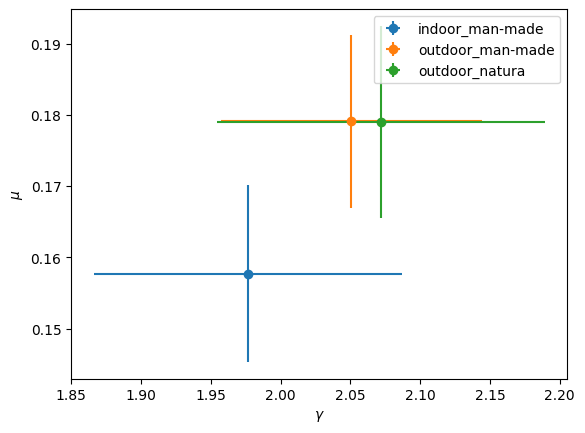

In [33]:
plot_a_b_per_group(expertcTMO_merge, "light_built")

In [34]:
[a_lum_mit5k_light_area, b_lum_mit5k_light_area] = param_distr_per_feature(expertcTMO_merge, "light_built")

['outdoor_natura', 'indoor_man-made', 'outdoor_man-made']


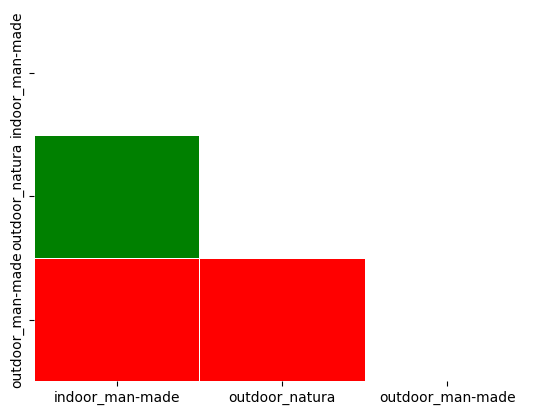

In [35]:
p_values_a_lum = ks_test(a_lum_mit5k_light_area, ['indoor_man-made', 'outdoor_natura', 'outdoor_man-made'], plot=True, alpha=0.05)

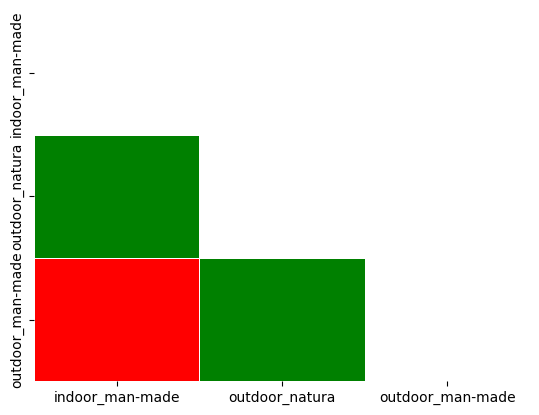

In [36]:
p_values_b_lum = ks_test(b_lum_mit5k_light_area, ['indoor_man-made', 'outdoor_natura', 'outdoor_man-made'], plot=True, alpha=0.05)

OUTDOOR VS INDOOR IS DIFFERENT